<a href="https://colab.research.google.com/github/LithiumDrache/BUSoftwareEngineeringUnit/blob/main/lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/04-pytorch-mnist.ipynb)


#Install packages and ngrok

In [ ]:
!pip install torch torchvision

In [ ]:
# Install ngrok
!pip install pyngrok

In [ ]:
# Set ngrok authtoken
from pyngrok import ngrok
ngrok.set_auth_token("2nFWCxCRCHgQHS2o9B4lHVFysuy_6MgjjwAfYm3Xhj7aPx9Di")

In [ ]:
# Function to start ngrok
def start_ngrok():
    # Start the ngrok process with subprocess, specifying that ngrok should tunnel HTTP traffic to port 5000
    ngrok_process = subprocess.Popen(['ngrok', 'http', '5000'])
    # Delay the script for 4 seconds to allow ngrok time to initialize and start the tunnel
    time.sleep(4)
    # Fetch the ngrok tunnel information using an HTTP GET request to ngrok's local API
    response = requests.get('http://localhost:4040/api/tunnels')
    # Parse the JSON response to get the details of the tunnel
    tunnel_info = response.json()
    # Extract the public URL where the ngrok tunnel is accessible
    public_url = tunnel_info['tunnels'][0]['public_url']
    # Print the ngrok tunnel URL to the console
    print(" * ngrok tunnel URL:", public_url)
    # Return the public URL for use elsewhere in the script
    return public_url

# ResNet with Flask

Up load imagenet_classes.txt:

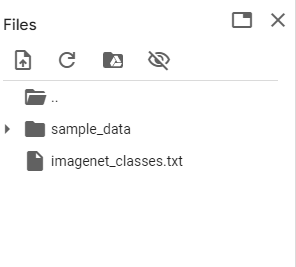

In [ ]:
# Import the required modules
import torch
from PIL import Image as PILImage
import torchvision.transforms as transforms
import torchvision.models as models
from flask import Flask, render_template_string, request, redirect, url_for
import os
import subprocess
import requests
import time
import uuid

# Load the pre-trained ResNet-152 model
def load_model():
    model = models.resnet152(pretrained=True)
    model.eval()
    return model

# Load the model
model = load_model()

# Load ImageNet classes
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

# Prediction function using ResNet-152
def predict_uploaded_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = PILImage.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    predicted_class = classes[predicted.item()]
    return predicted_class

# Initialize Flask app
app = Flask(__name__)

# Set upload folder inside the static directory
UPLOAD_FOLDER = 'static/uploads'
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# HTML template with file upload form
html_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Classification</title>
</head>
<body>
    <h1>Upload an Image for Classification</h1>
    <form method="post" action="/" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*">
        <button type="submit">Upload</button>
    </form>
    {% if prediction %}
        <h2>Predicted Class: {{ prediction }}</h2>
        <img src="{{ url_for('static', filename='uploads/' + uploaded_file) }}" alt="Uploaded Image" style="max-width: 500px;">
    {% endif %}
</body>
</html>
'''

# Route for the home page
@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    uploaded_file = None

    if request.method == 'POST':
        # Get the uploaded file
        file = request.files['file']
        if file:
            # Generate a unique filename using UUID
            unique_filename = f"{uuid.uuid4()}_{file.filename}"
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], unique_filename)
            file.save(file_path)

            # Run prediction
            prediction = predict_uploaded_image(file_path)

            # Store the uploaded file name for display
            uploaded_file = unique_filename

    return render_template_string(html_template, prediction=prediction, uploaded_file=uploaded_file)


# Main entry point of the application, this block runs when the script is executed directly
if __name__ == '__main__':
    # Start ngrok and store the public URL
    public_url = start_ngrok()
    # Print the public URL to access the web application
    print(f" * Access the web app at: {public_url}")
    # Run the Flask app on port 5000
    app.run(port=5000)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 * ngrok tunnel URL: https://1d93-34-125-72-163.ngrok-free.app
 * Access the web app at: https://1d93-34-125-72-163.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:18:11] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:18:12] "GET /favicon.ico HTTP/1.1" 404 -


# Exercise 1:
Add a reset button that clears the uploaded image and any displayed prediction results, allowing users to start a new upload.

In [ ]:
# Import the required modules
import torch
from PIL import Image as PILImage
import torchvision.transforms as transforms
import torchvision.models as models
from flask import Flask, render_template_string, request, redirect, url_for
import os
import subprocess
import requests
import time
import uuid

# Load the pre-trained ResNet-152 model
def load_model():
    model = models.resnet152(pretrained=True)
    model.eval()
    return model

# Load the model
model = load_model()

# Load ImageNet classes
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

# Prediction function using ResNet-152
def predict_uploaded_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = PILImage.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    predicted_class = classes[predicted.item()]
    return predicted_class

# Initialize Flask app
app = Flask(__name__)

# Set upload folder inside the static directory
UPLOAD_FOLDER = 'static/uploads'
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# HTML template with file upload form and reset button
html_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Classification</title>
</head>
<body>
    <h1>Upload an Image for Classification</h1>
    <form method="post" action="/" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*">
        <button type="submit">Upload</button>
    </form>
    <form method="post" action="/reset">

        <button type="submit">Reset</button

    </form>
    {% if prediction %}
        <h2>Predicted Class: {{ prediction }}</h2>
        <img src="{{ url_for('static', filename='uploads/' + uploaded_file) }}" alt="Uploaded Image" style="max-width: 500px;">
    {% endif %}
</body>
</html>
'''

# Route for the home page
@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    uploaded_file = None

    if request.method == 'POST':
        # Get the uploaded file
        file = request.files['file']
        if file:
            # Generate a unique filename using UUID
            unique_filename = f"{uuid.uuid4()}_{file.filename}"
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], unique_filename)
            file.save(file_path)

            # Run prediction
            prediction = predict_uploaded_image(file_path)

            # Store the uploaded file name for display
            uploaded_file = unique_filename

    return render_template_string(html_template, prediction=prediction, uploaded_file=uploaded_file)

# Route for resetting the uploaded image and prediction
@app.route('/reset', methods=['POST'])
def reset():
    # Redirect to the home page to clear the prediction and uploaded image
    return redirect(url_for('index'))

# Main entry point of the application, this block runs when the script is executed directly
if __name__ == '__main__':
    # Start ngrok and store the public URL
    public_url = start_ngrok()
    # Print the public URL to access the web application
    print(f" * Access the web app at: {public_url}")
    # Run the Flask app on port 5000
    app.run(port=5000)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 * ngrok tunnel URL: https://6be6-34-125-72-163.ngrok-free.app
 * Access the web app at: https://6be6-34-125-72-163.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:23:52] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:23:52] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:23:57] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:23:58] "GET /static/uploads/9b1d9c1f-1997-466a-a1ca-2a17343a5b76_FI.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:24:05] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:24:06] "GET /static/uploads/f76be14c-4953-4719-8c06-0354fbf14937_Puppy.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:24:09] "POST /reset HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:24:09] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:24:31] "POST / HTTP/1.

# Exercise 2:
Modify the font ("Upload an Image for Classification" and "Predicted Class:") style and color

In [ ]:
# Import the required modules
import torch
from PIL import Image as PILImage
import torchvision.transforms as transforms
import torchvision.models as models
from flask import Flask, render_template_string, request, redirect, url_for
import os
import subprocess
import requests
import time
import uuid

# Load the pre-trained ResNet-152 model
def load_model():
    model = models.resnet152(pretrained=True)
    model.eval()
    return model

# Load the model
model = load_model()

# Load ImageNet classes
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

# Prediction function using ResNet-152
def predict_uploaded_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = PILImage.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    predicted_class = classes[predicted.item()]
    return predicted_class

# Initialize Flask app
app = Flask(__name__)

# Set upload folder inside the static directory
UPLOAD_FOLDER = 'static/uploads'
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# HTML template with file upload form and reset button
html_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Classification</title>
</head>
<body>
    <h1 style="font-family: 'Papyrus', 'Comic Sans MS', serif;">Upload an Image for Classification</h1>
    <form method="post" action="/" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*">
        <button type="submit">Upload</button>
    </form>
    <form method="post" action="/reset">
        <button type="submit">Reset</button>
    </form>
    {% if prediction %}
        <h2 style="font-family: 'Papyrus', 'Comic Sans MS', serif;">Predicted Class: {{ prediction }}</h2>
        <img src="{{ url_for('static', filename='uploads/' + uploaded_file) }}" alt="Uploaded Image" style="max-width: 500px;">
    {% endif %}
</body>
</html>
'''

# Route for the home page
@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    uploaded_file = None

    if request.method == 'POST':
        # Get the uploaded file
        file = request.files['file']
        if file:
            # Generate a unique filename using UUID
            unique_filename = f"{uuid.uuid4()}_{file.filename}"
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], unique_filename)
            file.save(file_path)

            # Run prediction
            prediction = predict_uploaded_image(file_path)

            # Store the uploaded file name for display
            uploaded_file = unique_filename

    return render_template_string(html_template, prediction=prediction, uploaded_file=uploaded_file)

# Route for resetting the uploaded image and prediction
@app.route('/reset', methods=['POST'])
def reset():
    # Redirect to the home page to clear the prediction and uploaded image
    return redirect(url_for('index'))

# Main entry point of the application, this block runs when the script is executed directly
if __name__ == '__main__':
    # Start ngrok and store the public URL
    public_url = start_ngrok()
    # Print the public URL to access the web application
    print(f" * Access the web app at: {public_url}")
    # Run the Flask app on port 5000
    app.run(port=5000)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 * ngrok tunnel URL: https://feb3-34-125-72-163.ngrok-free.app
 * Access the web app at: https://feb3-34-125-72-163.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:36:12] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:36:13] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:36:21] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:36:21] "GET /static/uploads/5c90ee7c-2c7a-4b27-986d-b4698b33402c_Bananas.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:36:30] "POST /reset HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:36:30] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:37:03] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:37:04] "GET /static/uploads/643c340d-3bcf-41a9-aae4-4c4dfc70108e_Q.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 14:37:25] "POST / HTTP/1